In [5]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import warnings
from sklearn.cluster import DBSCAN # To instantiate and fit the model
from sklearn.metrics import pairwise_distances # For Model evaluation
from sklearn.neighbors import NearestNeighbors # For Hyperparameter Tuning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc
warnings.filterwarnings('ignore')

#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato/"
PATH_FROM_READ_ETL = "./dataset_originale/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato/" 


sns.set(font_scale=1.8)

In [6]:
df_team_stats = pd.read_csv("./ETL_Mat/stats_team.csv")

world_cup_winner = df_team_stats.groupby(['team_id'])[['finals_win']].agg('sum').reset_index().sort_values(by="team_id",ascending=True)
world_cup_winner.loc[world_cup_winner["finals_win"]>0, "finals_win"] = 1
world_cup_winner = world_cup_winner.rename(columns={"finals_win": "world_cup_winner"})
df_team_stats = df_team_stats.merge(world_cup_winner, on="team_id", how="left")

world_cup_winner = df_team_stats['world_cup_winner']

In [7]:
df_team_stats.head()

,team_id,goal_differential,win_lose_differential,yellow_card,red_card,player_per_teams,world_cup_appearence,finals_reached,finals_win,different_managers,goals_for,goals_against,team_name,world_cup_winner
0,T-01,-6,-4,19,2,57,4,0,0,4,13,19,Algeria,0
1,T-02,-1,-1,12,1,17,1,0,0,1,1,2,Angola,0
2,T-03,44,23,122,7,221,17,5,2,15,137,93,Argentina,1
3,T-04,-18,-8,33,4,63,5,0,0,5,13,31,Australia,0
4,T-05,-4,-1,23,1,93,7,0,0,8,43,47,Austria,0


In [8]:
df_team_stats.drop("team_id", axis=1).describe()

,goal_differential,win_lose_differential,yellow_card,red_card,player_per_teams,world_cup_appearence,finals_reached,finals_win,different_managers,goals_for,goals_against,world_cup_winner
count,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000
mean,-0.650602,-0.325301,29.024096,1.963855,73.638554,5.506024,0.530120,0.253012,4.746988,29.120482,29.771084,0.096386
std,21.788582,9.337974,26.671889,2.238498,61.588045,4.988703,1.524894,0.895018,3.828148,39.591634,25.189683,0.296913
min,-38.000000,-13.000000,0.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
25%,-9.500000,-4.500000,9.000000,1.000000,20.000000,1.000000,0.000000,0.000000,1.000000,4.000000,10.000000,0.000000
50%,-4.000000,-2.000000,20.000000,1.000000,57.000000,4.000000,0.000000,0.000000,4.000000,13.000000,22.000000,0.000000
75%,0.500000,0.500000,40.000000,2.000000,103.000000,8.000000,0.000000,0.000000,7.000000,38.500000,45.000000,0.000000
max,124.000000,57.000000,122.000000,9.000000,262.000000,21.000000,8.000000,5.000000,15.000000,229.000000,105.000000,1.000000


In [9]:
# drop useless columns
df_team_stats = df_team_stats.drop(['team_name','team_id', 'goals_for','goals_against','world_cup_winner'], axis=1)
df_team_stats.isnull().sum(axis = 0)

goal_differential        0
win_lose_differential    0
yellow_card              0
red_card                 0
player_per_teams         0
world_cup_appearence     0
finals_reached           0
finals_win               0
different_managers       0
dtype: int64

In [10]:
# Create dummies - for better model outcomes
df_team_stats = pd.get_dummies(df_team_stats)
df_team_stats.head()

,goal_differential,win_lose_differential,yellow_card,red_card,player_per_teams,world_cup_appearence,finals_reached,finals_win,different_managers
0,-6,-4,19,2,57,4,0,0,4
1,-1,-1,12,1,17,1,0,0,1
2,44,23,122,7,221,17,5,2,15
3,-18,-8,33,4,63,5,0,0,5
4,-4,-1,23,1,93,7,0,0,8


In [11]:
# Data Normalization
names = df_team_stats.columns
scaler = MinMaxScaler()
scaled_d = scaler.fit_transform(df_team_stats[["goal_differential", "win_lose_differential",'yellow_card','red_card','player_per_teams','world_cup_appearence','finals_reached','finals_win','different_managers']])
df_team_stats[["goal_differential", "win_lose_differential",'yellow_card','red_card','player_per_teams','world_cup_appearence','finals_reached','finals_win','different_managers']] = scaled_d
df_team_stats.head()

,goal_differential,win_lose_differential,yellow_card,red_card,player_per_teams,world_cup_appearence,finals_reached,finals_win,different_managers
0,0.197531,0.128571,0.155738,0.222222,0.183267,0.15,0.000,0.0,0.214286
1,0.228395,0.171429,0.098361,0.111111,0.023904,0.00,0.000,0.0,0.000000
2,0.506173,0.514286,1.000000,0.777778,0.836653,0.80,0.625,0.4,1.000000
3,0.123457,0.071429,0.270492,0.444444,0.207171,0.20,0.000,0.0,0.285714
4,0.209877,0.171429,0.188525,0.111111,0.326693,0.30,0.000,0.0,0.500000


In [12]:
df_team_stats['world_cup_winner'] = pd.Series(world_cup_winner)

# Class balance
ld = df_team_stats[df_team_stats.world_cup_winner == 1]
no_ld = df_team_stats[df_team_stats.world_cup_winner == 0]
print("WORLD CUP WINNER: ", len(ld), " WORLD CUP NOT WINNER: ", len(no_ld))

WORLD CUP WINNER:  8  WORLD CUP NOT WINNER:  75


In [13]:
balanced_d = pd.concat([ld, no_ld.sample(len(ld))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(16, 10)

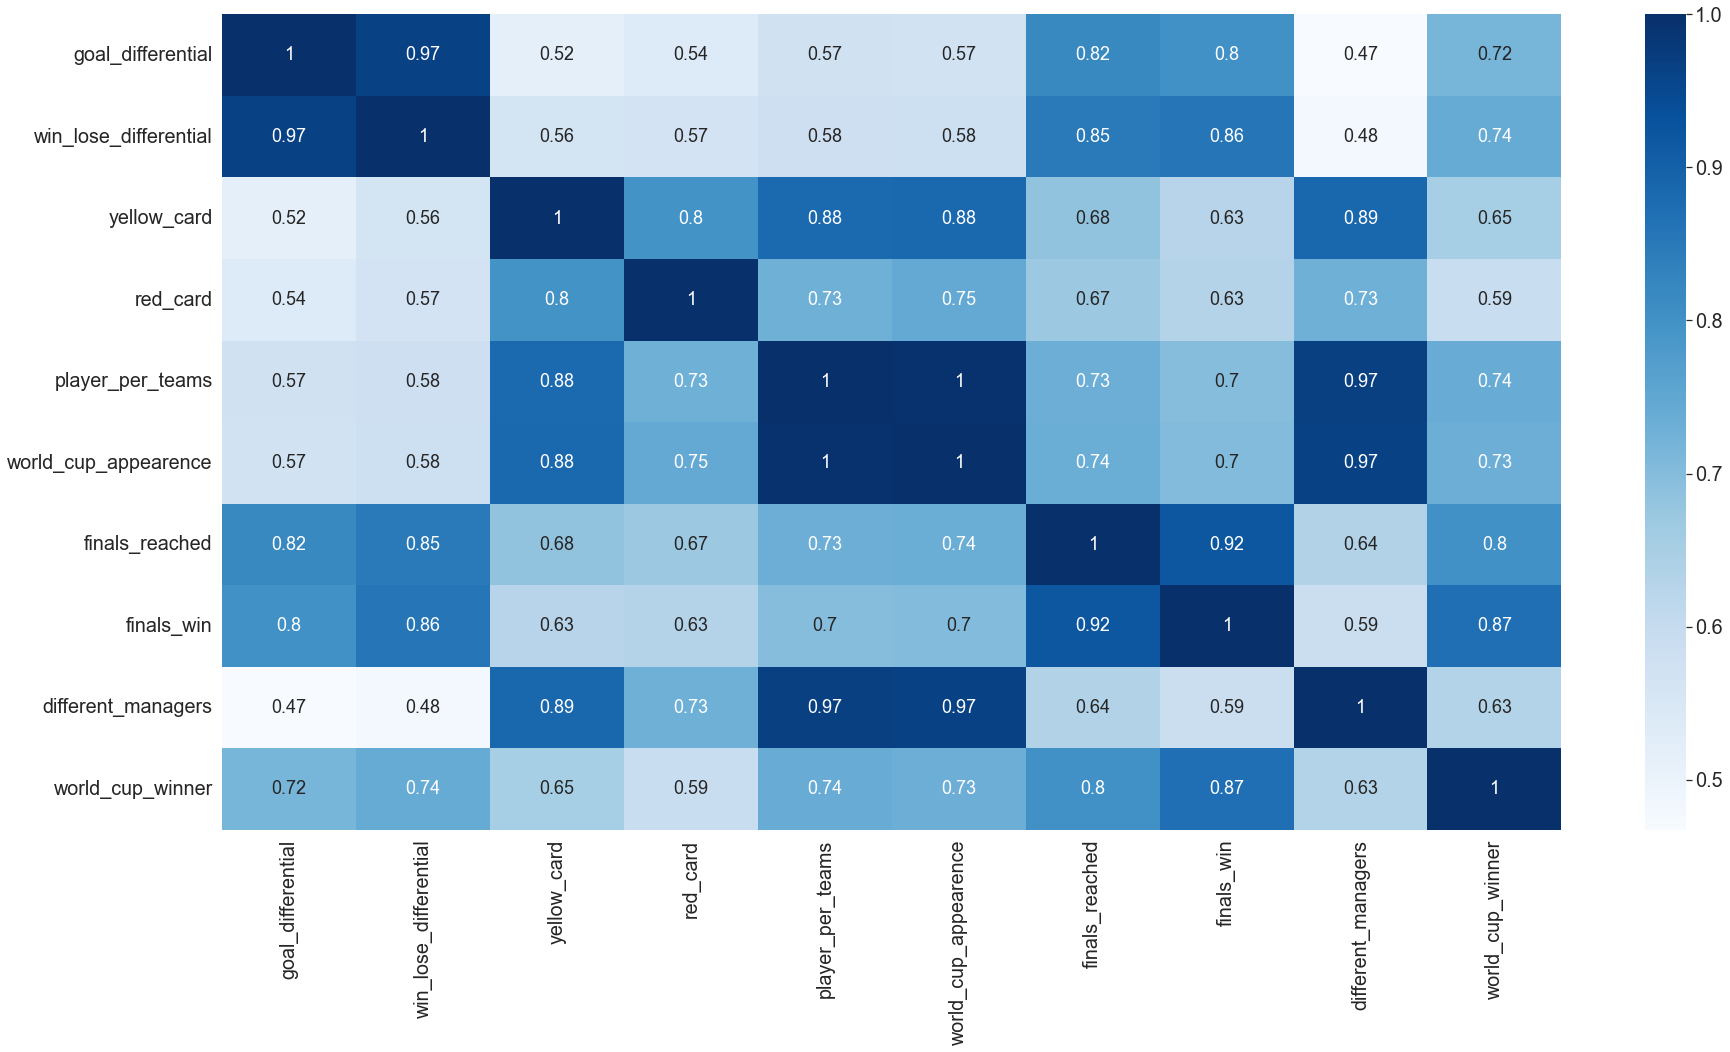

In [14]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(df_team_stats[df_team_stats.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [15]:
# Drop values to avoid variables with too high correlation
x = x.drop(['win_lose_differential', 'world_cup_appearence','yellow_card','finals_reached','player_per_teams','finals_win'], axis=1)

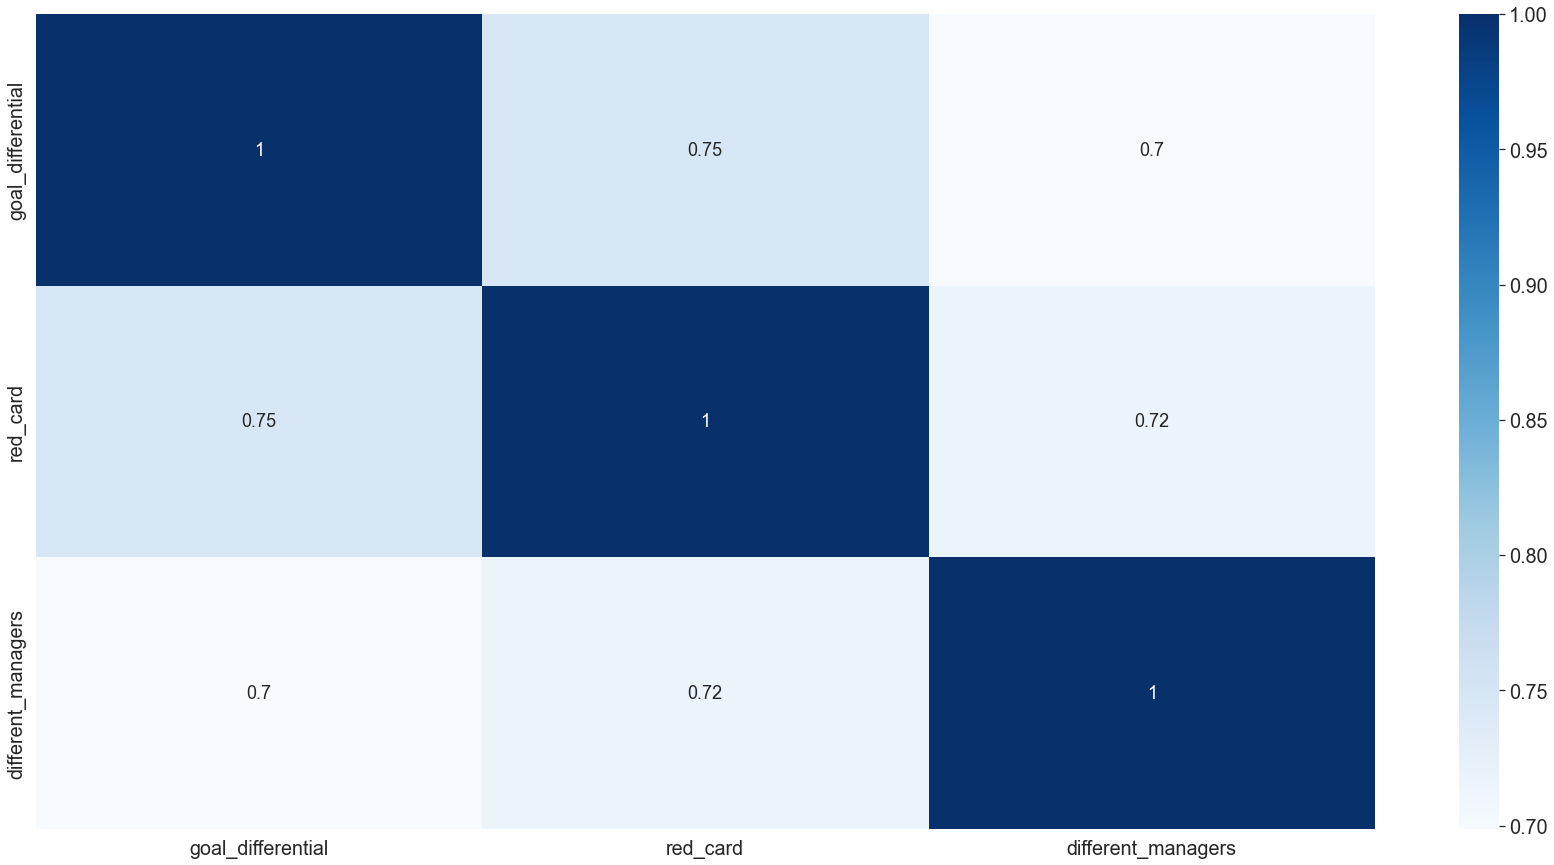

In [16]:
# Check for correlation
#d.corr() #less representative way
plt.figure(figsize=(30,15))
ax = sns.heatmap(x.corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [17]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(12, 3)
(4, 3)
(12, 1)
(4, 1)


In [18]:
# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs),
    SVC(probability=True),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    AdaBoostClassifier(n_estimators=10, random_state=rs),
    GradientBoostingClassifier(n_estimators=10, random_state=rs),
    LinearDiscriminantAnalysis(),
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [19]:
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Accuracy: 1.0 	 ---> LogisticRegression 
Accuracy: 1.0 	 ---> DecisionTreeClassifier 
Accuracy: 1.0 	 ---> SVC 
Accuracy: 1.0 	 ---> RandomForestClassifier 
Accuracy: 1.0 	 ---> AdaBoostClassifier 
Accuracy: 1.0 	 ---> GradientBoostingClassifier 
Accuracy: 1.0 	 ---> LinearDiscriminantAnalysis 


Text(0.5, 1.0, 'Cross validation scores')

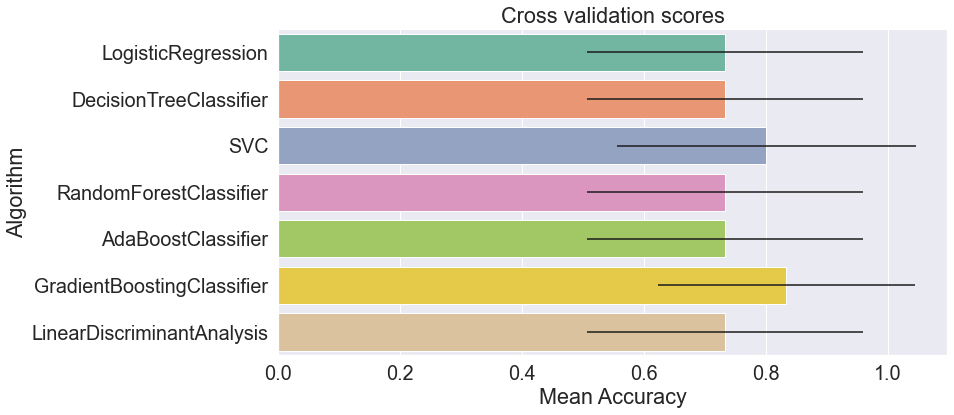

In [20]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

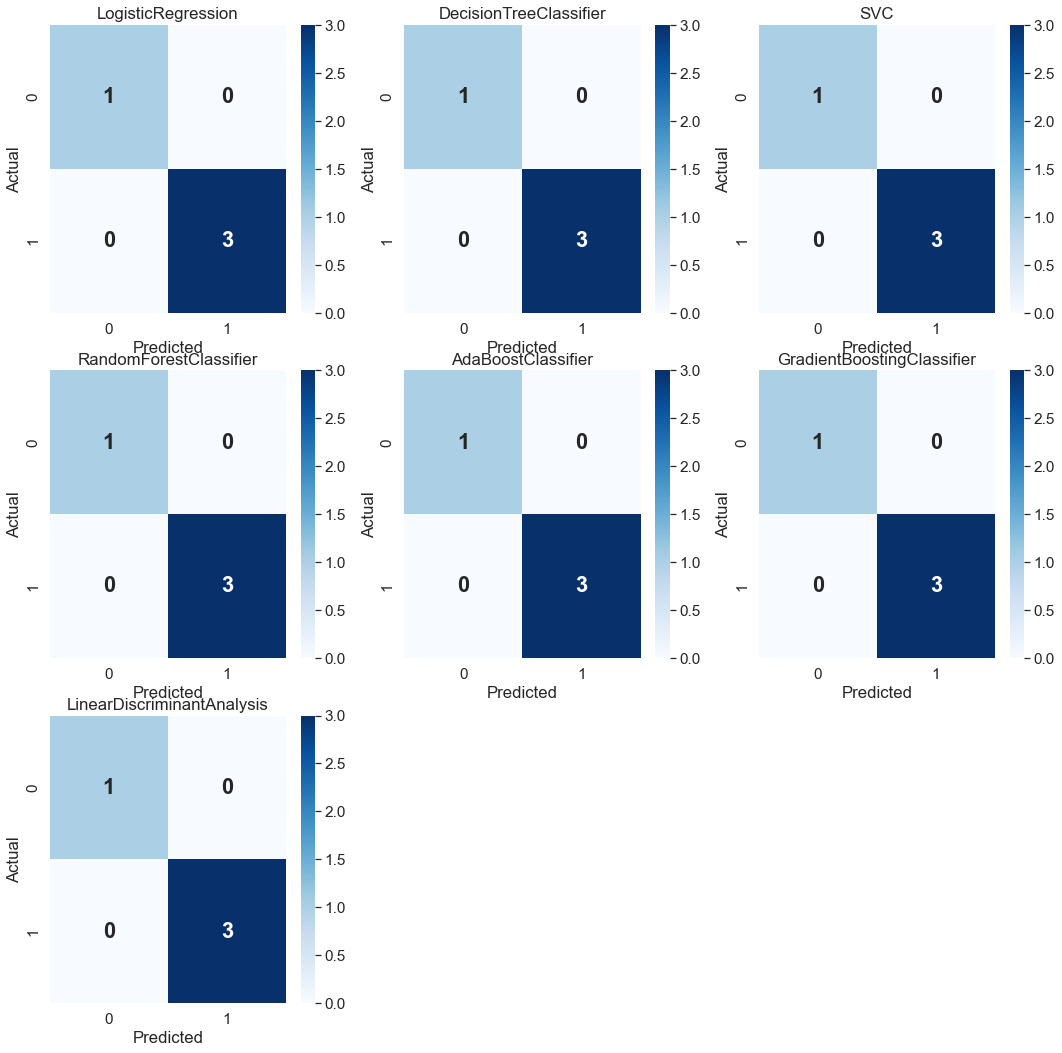

In [33]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(18,18))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues", annot_kws={
                'fontsize': 22,
                'fontweight': 'bold'})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [22]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

SVC Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg 

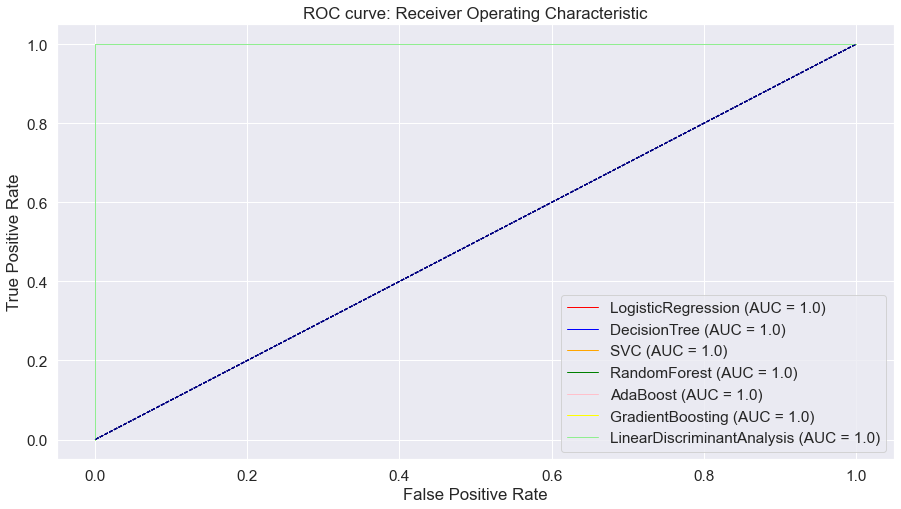

In [23]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [25]:
# Search grid for optimal parameters

DT_param = {"max_depth": [2,3,8,10],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "criterion": ["gini"]}

RF_param = {"max_depth": [None],
            "max_features": [0.3, 0.7, 1],
            "min_samples_split": [2, 3, 10],
            "min_samples_leaf": [1, 3, 10],
            "bootstrap": [False],
            "n_estimators" :[100,300],
            "criterion": ["gini"]}

#using 4 n_jobs for faster processing
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)
RFgs = GridSearchCV(RandomForestClassifier(), param_grid=RF_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [DTgs, RFgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [26]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[1], 3), round(cv_acc[3], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

score without GridSearchCV:  0.733 0.733
score with GridSearchCV:  1.0 0.9


In [27]:
model_results

,world_cup_winner,LogisticRegression,DecisionTreeClassifier,SVC,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,LinearDiscriminantAnalysis
2,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
38,1,1,1,1,1,1,1,1
82,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Correlation between models')

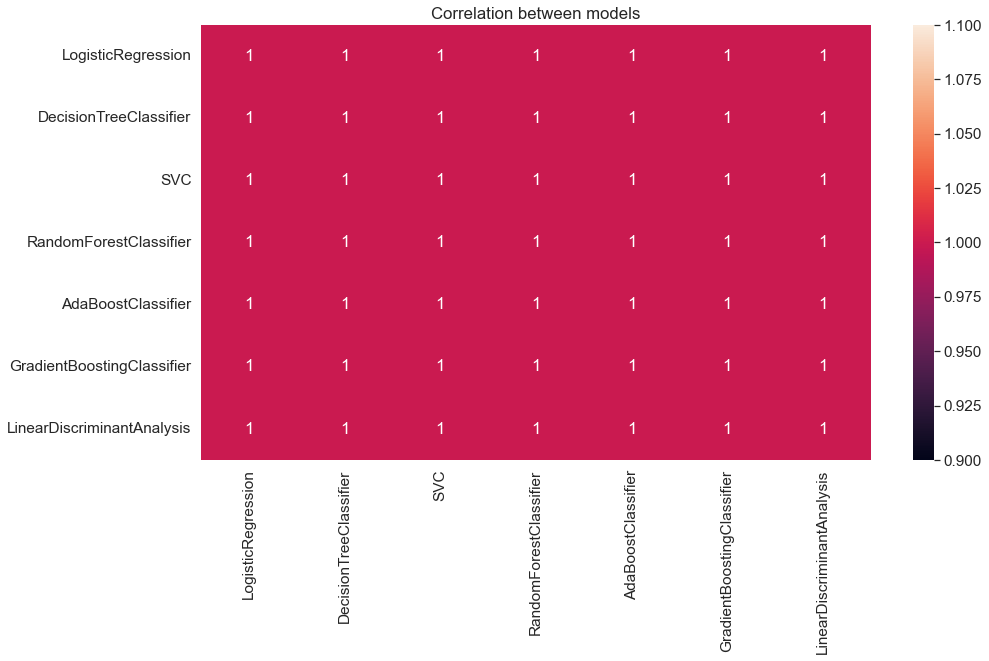

In [28]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop("world_cup_winner", axis=1).corr(),annot=True)
plt.title("Correlation between models")

In [29]:
# Do model ensembling
best_model = VotingClassifier(estimators=[('dt', gs_model[0]), ('rf', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

1.0


In [30]:
# Load the test data
d2 = pd.read_csv("./ETL_Mat/stats_team.csv")
Team_Id = d2['team_id'] #save this variable for correct format of the submision

# Drop values
d2 = d2.drop(['team_id', 'team_name','goals_for','goals_against'], axis=1)

# Dealing with null values, for numerical:
for col in d2.columns:
    if d2[col].dtype != object:
        d2[col]=d2[col].fillna(df_team_stats[col].mean())

# Create dummies - for better model outcomes (also deals with nulls in categorical)
d2 = pd.get_dummies(d2)

# Data Normalization

scaled_d2 = scaler.transform(d2[["goal_differential", "win_lose_differential",'yellow_card','red_card','player_per_teams','world_cup_appearence','finals_reached','finals_win','different_managers']])

d2[["goal_differential", "win_lose_differential",'yellow_card','red_card','player_per_teams','world_cup_appearence','finals_reached','finals_win','different_managers']] = scaled_d2

# Drop values to avoid multicolinearity
d2 = d2.drop(['win_lose_differential', 'world_cup_appearence','yellow_card','finals_reached','player_per_teams','finals_win'], axis=1)

In [31]:
#train the model on the whole dataset and produce results:
survived_pred = pd.Series(best_model.predict(d2), name='world_cup_winner')

In [32]:
survived_pred.value_counts()

0    69
1    14
Name: world_cup_winner, dtype: int64

In [ ]:
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

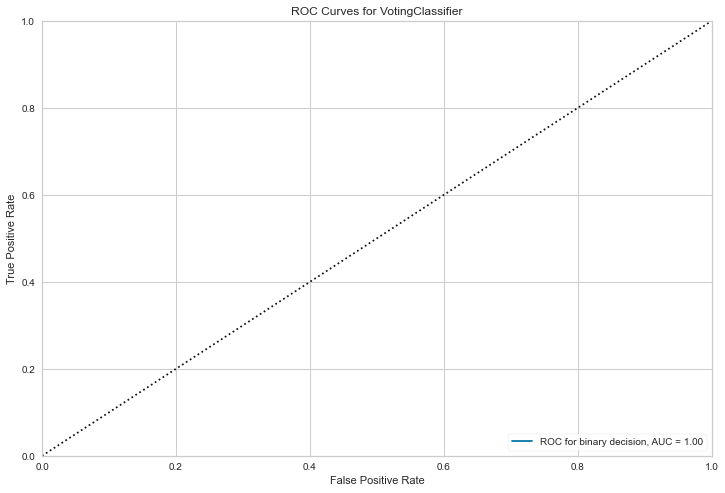

<AxesSubplot:title={'center':'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["world_cup_not_winner", "world_cup_winner"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

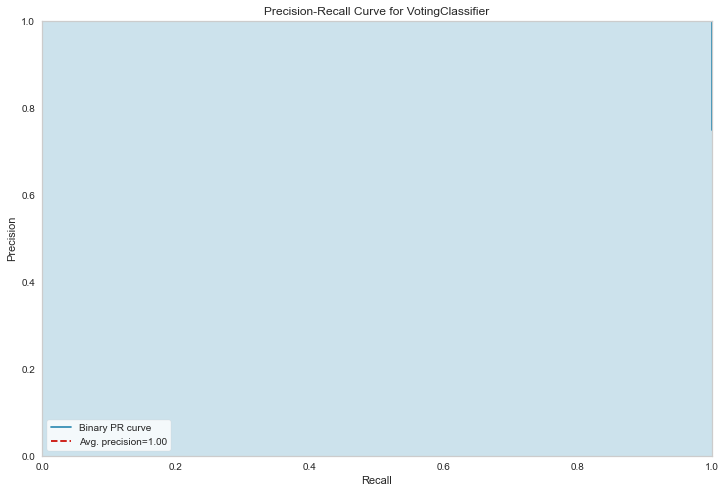

<AxesSubplot:title={'center':'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

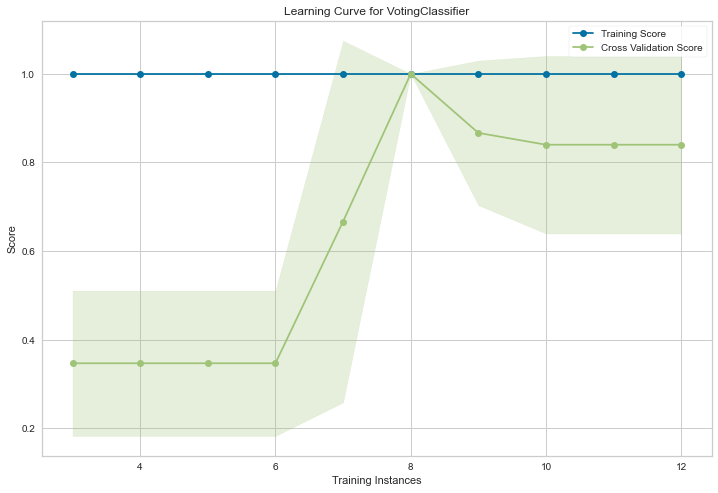

<AxesSubplot:title={'center':'Learning Curve for VotingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure